## SeeFood 

For our final project, we wrote a Convolutional Neural Network (CNN) that recognizes whether a 
food image is or is not a hot dog. Our dataset is from [Kaggle](https://www.kaggle.com/datasets/dansbecker/hot-dog-not-hot-dog?datasetId=8552&sortBy=relevance&searchQuery=CNN),
which is compiled from a dataset of 101 different food items. It is separated into test and train 
folders from the get-go, each with 250 pictures of hot dogs and 250 pictures of other food items.
This is a total of 1000 pictures.

In [503]:
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, RandomRotation, RandomZoom
import numpy as np
import os
import cv2
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

These are constants we use throughout the project, including number of epochs and image dimensions.

In [504]:
img_width, img_height = 50, 50
input_shape = (img_width, img_height, 1)
batch_size = 25
num_epochs = 25
num_classes = 2
validation_split = 0.2

#### Image Preprocessing

Here we load the images from the dataset. Based on the `data_type` and `class_type` arguments, we can load test and train data, split into the `hot_dog` and `not_hot_dog` classes.

Because the images of are of various sizes and in color, we have to do some preprocessing to the pictures. We first load
it in grayscale, so that it easier for the neural network to process. Then, we resize the image to
50 x 50 px.

In [505]:
def load_data(data_type, class_type):
    images = []
    labels = []

    for file in os.listdir(f'data/{data_type}/{class_type}'):
        image = cv2.resize(cv2.imread(f'data/{data_type}/{class_type}/{format(file)}', 0), (img_width, img_height))
        images.append(image)
        labels.append(0 if class_type == 'not_hot_dog' else 1)

    return (images, labels)

In [506]:
# load and merge training data
X_train_nh, y_train_nh = load_data(data_type="train", class_type="not_hot_dog")
X_train_h, y_train_h = load_data(data_type="train", class_type="hot_dog")
X_train = np.array(X_train_nh + X_train_h)

# rotation_layer = RandomRotation(0.5)
# rotation_layer = RandomZoom()
# X_train_aug = rotation_layer(X_train).numpy()

# X_train = np.array(X_train + X_train_aug)

X_train = X_train.reshape((X_train.shape[0], img_width, img_height, 1))
y_train = np.array(y_train_nh + y_train_h)

# load and merge testing data
X_test_nh, y_test_nh = load_data(data_type="test", class_type="not_hot_dog")
X_test_h, y_test_h = load_data(data_type="test", class_type="hot_dog")
X_test = np.array(X_test_nh + X_test_h)
X_test = X_test.reshape((X_test.shape[0], img_width, img_height, 1))
y_test = np.array(y_test_nh + y_test_h)

A picture of french fries and a hot dog after the preprocessing.

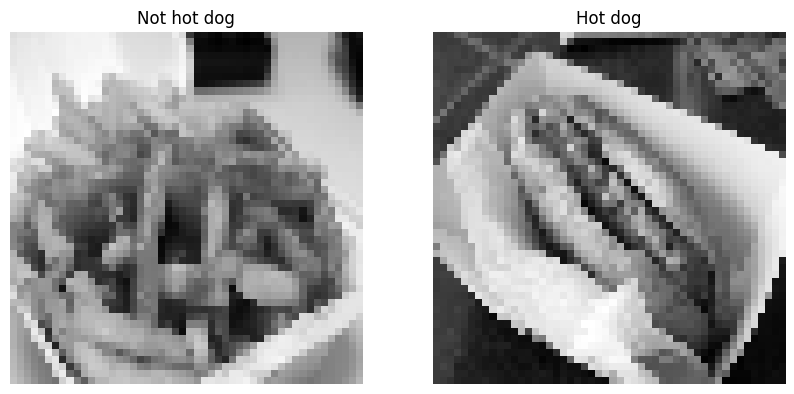

In [507]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(X_train_nh[0], cmap="gray")
axes[0].set_title("Not hot dog")
axes[0].axis("off")

axes[1].imshow(X_train_h[0], cmap="gray")
axes[1].set_title("Hot dog")
axes[1].axis("off")

plt.show()

#### Neural Network

Our neural network is a CNN with multiple layers. The first three layers are convolutional layers: (1) input layer with 25 filters, (2) secondary layer with 50 filters, (3) third layer with 100 filters. These convolutional layers are used to extract features from the input images, with each layer learning increasingly complex patterns. The next layer flattens the multidimensional output into a one dimensional layer. This is needed for the dense layers, which are fully connected with 256 neurons and give us our output.

In [508]:
model = Sequential()
model.add(Conv2D(25, kernel_size=(3, 3), activation="relu", input_shape=input_shape))
model.add(Conv2D(50, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(100, kernel_size=(3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(num_classes, activation="softmax"))

In [509]:
model.compile(loss=tensorflow.keras.losses.sparse_categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [510]:
# earlystop_cb = EarlyStopping(patience=3)

# data_gen = ImageDataGenerator(
#     rotation_range=40,        
#     width_shift_range=0.2,   
#     height_shift_range=0.2, 
#     shear_range=0.2,       
#     zoom_range=0.2,       
#     horizontal_flip=True,
#     fill_mode='nearest' 
# )

# data_gen.fit(X_train)
# train_iterator = data_gen.flow(X_train, y_train, batch_size=batch_size)

# history = model.fit(
#     train_iterator,
#     steps_per_epoch=len(X_train) // batch_size,
#     epochs=num_epochs,
#     callbacks=[earlystop_cb],
#     shuffle=True,
#     validation_data=(X_test, y_test)
# )

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    shuffle=True,
                    # callbacks=[earlystop_cb],
                    validation_split=validation_split)

Epoch 1/25
16/16 [==============================] - 2s 96ms/step - loss: 285.4304 - accuracy: 0.5302 - val_loss: 4.6458 - val_accuracy: 0.0500
Epoch 2/25
16/16 [==============================] - 1s 64ms/step - loss: 0.6379 - accuracy: 0.7186 - val_loss: 1.1486 - val_accuracy: 0.2500
Epoch 3/25
16/16 [==============================] - 1s 62ms/step - loss: 0.3005 - accuracy: 0.9171 - val_loss: 1.5359 - val_accuracy: 0.4900
Epoch 4/25
16/16 [==============================] - 1s 63ms/step - loss: 0.1540 - accuracy: 0.9472 - val_loss: 2.4908 - val_accuracy: 0.3000
Epoch 5/25
16/16 [==============================] - 1s 62ms/step - loss: 0.0493 - accuracy: 0.9874 - val_loss: 3.7735 - val_accuracy: 0.4000
Epoch 6/25
16/16 [==============================] - 1s 63ms/step - loss: 0.0592 - accuracy: 0.9774 - val_loss: 5.7951 - val_accuracy: 0.2400
Epoch 7/25
16/16 [==============================] - 1s 62ms/step - loss: 0.0428 - accuracy: 0.9899 - val_loss: 4.3740 - val_accuracy: 0.3700
Epoch 8/25


After running the model for 25 epochs, we have a pretty mediocre accuracy of around 50%.

In [515]:
score = model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 32ms/step - loss: 7.1023 - accuracy: 0.5320


To evaluate our model, we show the confusion matrix and some metrics.

In [516]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
cm

16/16 [==============================] - 0s 28ms/step


array([[174,  76],
       [158,  92]])

In [517]:
tn, fp, fn, tp = cm.ravel()
pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1"],
    "Value": [(tp+tn)/(tp+fp+fn+tn), tp/(tp+fp), tp/(tp+fn), (2*tp/(tp+fp))*(tp/(tp+fn)) / ((tp/(tp+fp))+(tp/(tp+fn)))]
})

,Metric,Value
0,Accuracy,0.532000
1,Precision,0.547619
2,Recall,0.368000
3,F1,0.440191


Here is a plot showing the training and validation loss along with their accuracy. As you can see, the validation loss and accuracy are not very good for this model. They don't converge with the rest of the training data. We believe this is because the network overfits to the training data.

In [518]:
# extract loss values from the training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
epochs = list(range(1, len(train_loss) + 1))

# loss plot
p1 = figure(title="Training and Validation Loss", x_axis_label="Epoch", y_axis_label="Loss")
p1.line(epochs, train_loss, legend_label="Train Loss", line_color="blue")
p1.line(epochs, valid_loss, legend_label="Validation Loss", line_color="red")

# extract accuracy values
train_accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']
epochs = list(range(1, len(train_accuracy) + 1))

# accuracy plot
p2 = figure(title="Training and Validation Accuracy", x_axis_label="Epoch", y_axis_label="Accuracy")
p2.line(epochs, train_accuracy, legend_label="Train Accuracy", line_color="blue")
p2.line(epochs, valid_accuracy, legend_label="Validation Accuracy", line_color="red")

# arrange the plots in a grid
grid = gridplot([[p1, p2]])
show(grid)